In [3]:
from DataModules import MNISTSuperpixelDataModule
from models.ebm import DeepEnergyModel
import lightning as pl
import torch
from torch_geometric.data import Data, Batch

pl.seed_everything(2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CHECKPOINT: str = "../graph_logs/lightning_logs/version_18/checkpoints/epoch=50-step=4590.ckpt"
MNIST_PATH = "../datasets/MNISTSuperpixel"
data_module = MNISTSuperpixelDataModule(data_dir=MNIST_PATH, num_workers=4, batch_size=4)
data_module.setup("fit")
loader = data_module.train_dataloader()
batch = next(iter(loader))

model = DeepEnergyModel.load_from_checkpoint(CHECKPOINT)
model.eval()

def generate_random_graph(num_nodes: int = 75, num_edges: int = 1500, device: torch.device = torch.device('cpu')) -> Data:
    edges: torch.Tensor = torch.randint(0, num_nodes, (num_edges, 2), dtype=torch.long)
    x: torch.Tensor = torch.rand((num_nodes, 1))
    return Data(x=x, edge_index=edges.t().contiguous()).coalesce().to(device)

y = batch.y
pos = batch.pos
print(y)

Seed set to 2


tensor([1, 0, 0, 1])


In [4]:
starting_graphs: Batch = Batch.from_data_list([generate_random_graph(device=device) for _ in range(4)])
generated = model.sampler.generate_samples(model.cnn, starting_graphs, y, 1024, 1)

print(generated)

DataBatch(x=[300, 1], edge_index=[2, 16318], batch=[300], ptr=[5])


/home/mancio/git/ebm-molecules/.venv/lib/python3.12/site-packages/torch_geometric/utils/sparse.py:74: UserWarning: Mask should not be provided in case the dense adjacency matrix is two-dimensional
  warnings.warn("Mask should not be provided in case the dense "


In [5]:
plot_batch = Batch.to_data_list(generated)
plot_batch[0].y = torch.tensor([y[0]])
plot_batch[0].pos = pos[:75]

plot_batch[1].y = torch.tensor([y[1]])
plot_batch[1].pos = pos[75:150]

plot_batch[2].y = torch.tensor([y[2]])
plot_batch[2].pos = pos[150:225]

plot_batch[3].y = torch.tensor([y[3]])
plot_batch[3].pos = pos[225:300]

plot_batch = Batch.from_data_list(plot_batch)
plot_batch

DataBatch(x=[300, 1], edge_index=[2, 16318], y=[4], pos=[300, 2], batch=[300], ptr=[5])

In [1]:
from utils.graphs import superpixels_to_2d_image
import matplotlib.pyplot as plt

def plot_graph(batch):
    fig, axes = plt.subplots(1, len(batch), figsize=(10, 6))
    axes = axes.flatten()
    for i in range(len(batch)):
        image = superpixels_to_2d_image(batch[i])
        axes[i].imshow(image, cmap=plt.cm.binary)
        axes[i].axis("off")
        axes[i].set_title(f"{batch[i].y.item()}")
    return fig

ModuleNotFoundError: No module named 'utils'

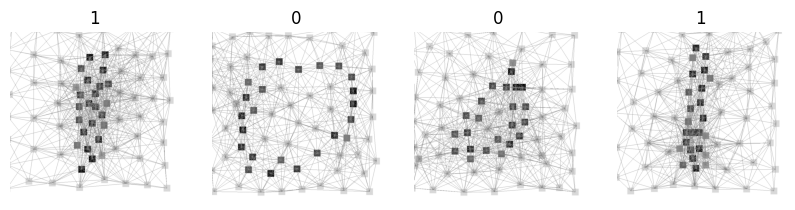

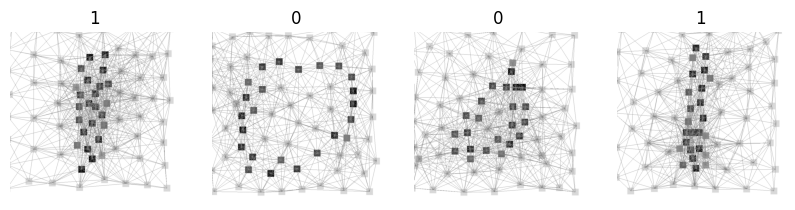

In [9]:
plot_graph(batch)

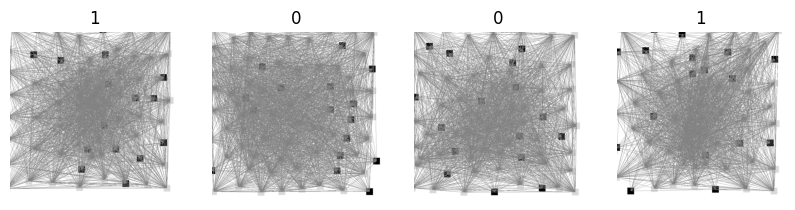

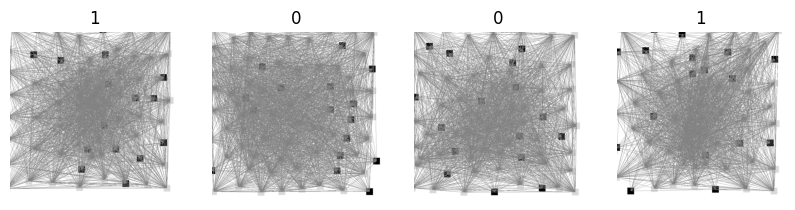

In [10]:
plot_graph(plot_batch)